# FORCE learning of the readout weights

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import water_tank as wt

Let's first generate the Mackey-Glass data:

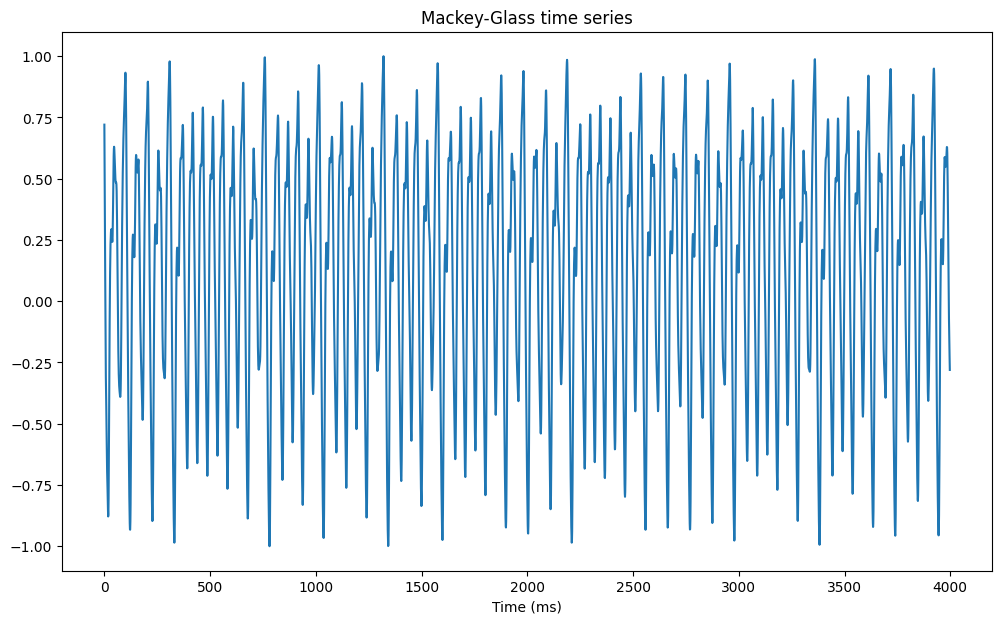

In [2]:
from reservoirpy.datasets import mackey_glass

# Generate time series
mg = mackey_glass(4000, x0=1.2)

# Normalize between -1 and 1
mg =  2.0 * (mg - mg.min()) / (mg.max() - mg.min()) - 1.0

# The task is to predict the next value
X = mg[:-1, 0]
Y = mg[1:, 0]

plt.figure(figsize=(12, 7))
plt.plot(X)
plt.xlabel("Time (ms)")
plt.title("Mackey-Glass time series")
plt.show()

To implement FORCE learning, we create an echo-state network with:

* a reservoir with $N$ tanh neurons.
* a readout layer with one neuron, with **feedback** to the reservoir.

The weight matrices are initialized classically. 

The readout weights are trained online using the **recursive least squares** (RLS) method as before. 


In [3]:
class ESN(object):

    def __init__(self, N, N_out, g, tau, sparseness):

        # Reservoir 
        self.rc = wt.layers.RecurrentLayer(size=N, tau=tau)

        # Readout
        self.readout = wt.layers.LinearReadout(size=N_out)

        # Recurrent projection
        self.rec_proj = wt.connect(
            pre = self.rc, 
            post = self.rc, 
            weights = wt.random.Normal(0.0, g/np.sqrt(sparseness*N)), 
            bias = wt.random.Bernouilli([-1.0, 1.0], p=0.5),
            sparseness = sparseness)

        # Readout projection
        self.readout_proj = wt.connect(
            pre = self.rc, 
            post = self.readout,
            weights = wt.random.Const(0.0),
            bias = wt.random.Const(0.0), # learnable bias
            sparseness = 1.0 # readout should be dense
        )

        # Feedback projection
        self.feedback_proj = wt.connect(self.readout, self.rc, wt.random.Uniform(-1.0, 1.0))

        # Learning rules
        self.learningrule = wt.rules.RLS(projection=self.readout_proj, delta=1e-6)

        # Recorder
        self.recorder = wt.Recorder()

    @wt.measure
    def train(self, X, warmup=0):

        for t, x in enumerate(X): 

            # Steps 
            self.rc.step() 
            self.readout.step()

            # Learning
            if t >= warmup: self.learningrule.train(error= np.array([x]) - self.readout.output())

            # Recording
            self.recorder.record({
                'rc': self.rc.output(), 
                'readout': self.readout.output(),
            })
    
    @wt.measure
    def autoregressive(self, duration):

        for _ in range(duration): 

            # Steps 
            self.rc.step() 
            self.readout.step()

            # Recording
            self.recorder.record({
                'rc': self.rc.output(), 
                'readout': self.readout.output()
            })

In [4]:
N_out = 1 # number of outputs
N = 200 # number of neurons
g = 1.25 # scaling factor
tau = 3.3 # time constant
sparseness = 0.1 # sparseness of the recurrent weights

net = ESN(N, N_out, g, tau, sparseness)

We train the reservoir for 500 time steps and let it predict the signal autoregressively for 1000 steps.

In [5]:
# Training / test
d_train = 500
d_test = 1000

# Supervised training
net.train(X[:d_train], warmup=0)

# Autoregressive test
net.autoregressive(duration=d_test)

data = net.recorder.get()

Execution time: 43 ms
Execution time: 27 ms


The performance is quite comparable to the supervised RLS rule.

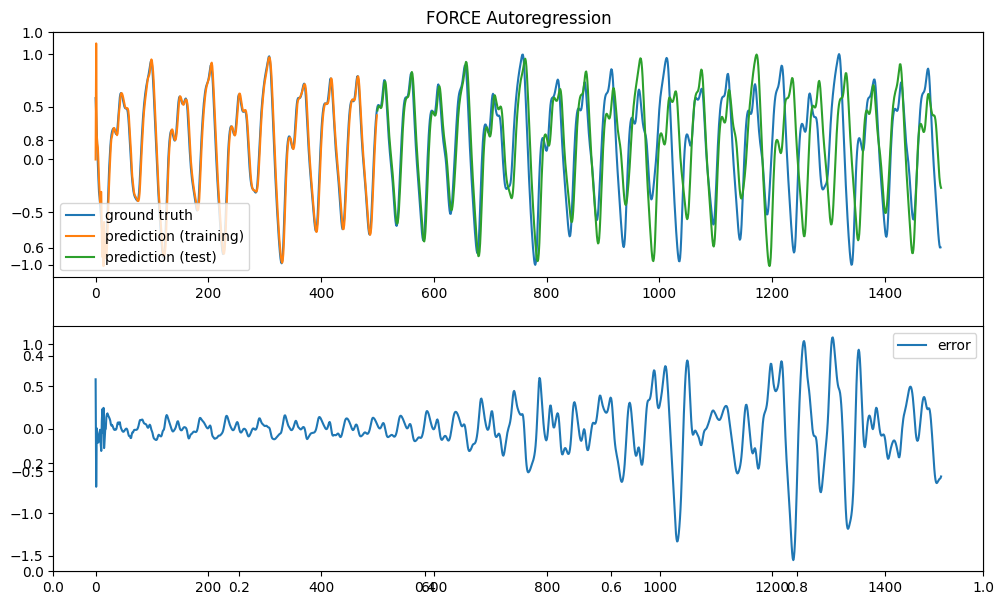

In [6]:
plt.figure(figsize=(12, 7))
plt.title("FORCE Autoregression")
plt.subplot(211)
plt.plot(Y[:d_train+d_test], label='ground truth')
plt.plot(data['readout'][:d_train], label='prediction (training)')
plt.plot(np.linspace(d_train, d_train+d_test, d_test), data['readout'][d_train:], label='prediction (test)')
plt.legend()
plt.subplot(212)
plt.plot(Y[:d_train+d_test] - data['readout'][:], label='error')
plt.legend()

plt.show()